<a href="https://colab.research.google.com/github/ds-kenwatanabe/google_colab_projects/blob/main/09_pytorch_model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 9. PyTorch Model Deployment

Machine learning model deployment is the act of making turning machine learning model(s) available to someone or something else.
See: https://www.learnpytorch.io/09_pytorch_model_deployment/

First Moldel - FoodVision Mini
https://huggingface.co/spaces/kenwatanabe/foodvision_pytorch

Second model - FoodVision Big
https://huggingface.co/spaces/kenwatanabe/foodvision_big

## 0. Setting up

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3881, done.
remote: Counting objects: 100% (1049/1049), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 3881 (delta 979), reused 943 (delta 932), pack-reused 2832
Receiving objects: 100% (3881/3881), 647.98 MiB | 36.80 MiB/s, done.
Resolving deltas: 100% (2272/2272), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting data
The dataset used for deploying the FoodVision Mini model is the:
pizza, steak, sushi 20% (20% random samples of Food101, with three classes, pizza, steak, sushi).

In [3]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [4]:
# Set up training and test paths
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## 2. FoodVision Mini model deployment experiment outline

### Three questions:
1. What is the ideal machine learning deployment scenario?
2. Where is the model going to?
3. How is the model going to function?

**FoodVision Mini ideal use case:** A model that performs well and fast

    1. Performs well = 95%+ accuracy
    2. Fast = as close as real time (30 fps+ or 3ms latency)

To achieve those goals, two models will be built:

    1. EffNetB2 feature extractor
    2. ViT feature extractor

## 3. Creating an EffNetB2 feature extractor

Feature extractor = a term for a transfer learning model that has its base layers frozen and output layers (head layers) customize for a certain problem.

EffNetB2 pretrained model in pytorch: https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.EfficientNet_B2_Weights

In [5]:
# 1. Set up pretrained EffNetB2 weights
effnet_b2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnet_b2_weights.transforms

# 3. Set up pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effnet_b2_weights)
# Could also use weights="DEFAULT"

# 4. Freeze the base layers in the model (stop layers from training)
for param in effnetb2.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:02<00:00, 16.6MB/s]


In [6]:
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [7]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [8]:
# Set seeds for reproducibility
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
)

In [9]:
# Summary after classifier update
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.1 Creating a function to make an EffNetB2 feature extractor

In [10]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms, and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in the base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )

    return model, transforms

In [11]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [12]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [13]:
summary(effnetb2,
        input_size=(1, 3, 288, 288),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 288, 288]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 288, 288]     [1, 1408, 9, 9]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 288, 288]     [1, 32, 144, 144]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 288, 288]     [1, 32, 144, 144]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 144, 144]    [1, 32, 144, 144]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 144, 144]    [1, 32, 144, 144]    --                   --
│    └─Sequential (1)                                        [1, 32, 144, 144]    [1, 1

### 3.2 Creating DataLoaders for EffNetB2

In [14]:
# Set up DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [15]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 3.2 Training EffNetB2 feature extractor

In [16]:
from going_modular.going_modular import engine

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)

# Training function
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


### 3.4 Inspecting EffNetB2 loss curves

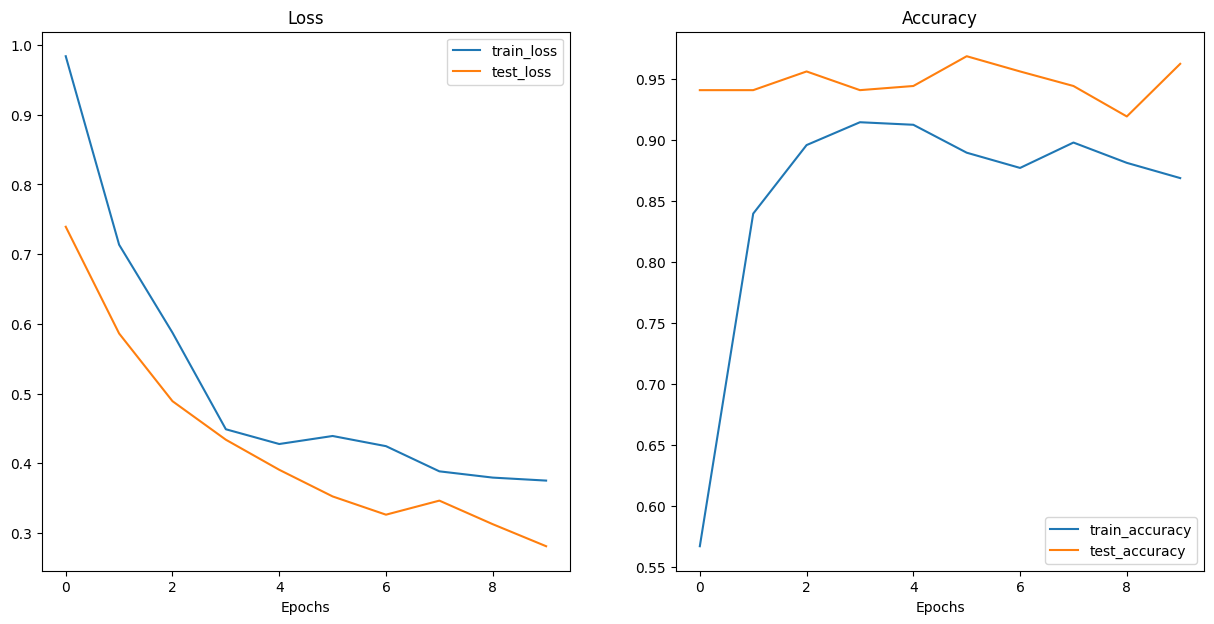

In [17]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### 3.5 Saving EffNetB2 feature extractor

In [18]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Inspecting the size of our EffNetb2 feature extractor

It is important to consider the size of a saved model, because if one wants to deploy the model to a mobile app/website, there may be limited compute resources.

If the model file is too large, we may not be able to store/run it on the target device.

In [19]:
from pathlib import Path

# Get the model size in bytes and convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size:.2f} MB")

Pretrained EffNetB2 feature extractor model size: 29.86 MB


### 3.7 Collecting EffNetB2 feature extractor stats

In [20]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [21]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}

effnetb2_stats

{'test_loss': 0.2810868680477142,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.863232612609863}

## 4. Creating a ViT feature extractor

Second modelling experiment, repeating step from EffNetB2, but using a ViT feature extractor.

In [22]:
# See head layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [23]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all of the base layers
    for param in model.parameters():
        param.requires_grad = False

    # Change the classifier head
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768,
                                          out_features=num_classes))

    return model, transforms

In [24]:
vit, vit_transforms = create_vit_model()
vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 115MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [25]:
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.1 Create DataLoaders for ViT feature extractor

In [26]:
# Set up ViT DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.3 Training ViT feature extractor

Model experiment #2, of ViT feature extractor

In [27]:
from going_modular.going_modular import engine

# Set up optimizer
optimizer = torch.optim.Adam(params=vit.parameters(), lr=1e-3)

# Set up loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT feature extractor with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


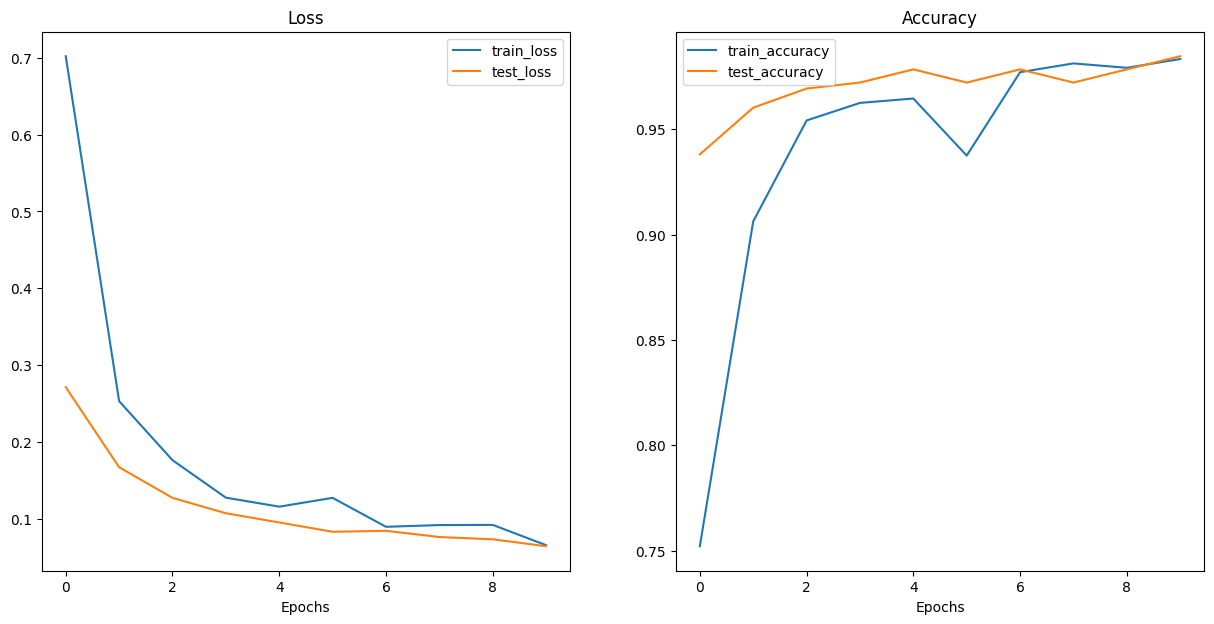

In [28]:
from helper_functions import plot_loss_curves
plot_loss_curves(vit_results)

### 4.4 Saving ViT feature extractor

In [29]:
# Save model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_precent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_precent.pth


### 4.5 Checking the size of ViT feature extractor

In [30]:
from pathlib import Path

# get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_precent.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size:.2f} MB")

Pretrained ViT feature extractor model size: 327.37 MB


### 4.6 Collecting ViT feature extractor stats

In [31]:
# Count the number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [32]:
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06443452024832368,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37038707733154}

## 5. Making predictions with our trained model and timing them

Our goal:

1. Performs weel (95%+ accuracy)
2. Is fast (30+ FPS)

To test criteria two:

1. Loop through test images
2. Time how long each model takes to make a prediction on the image

In [33]:
from pathlib import Path

# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1335842.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/289822.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2365038.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2756200.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1082384.jpg')]

### 5.1 Creating a function to make across the test dataset

Steps to create `pred_and_store()`:

1. Create a function that takes a list of paths and a trained PyTorch model and a series of transforms a list of target class names and a target device.
2. Create an empty list (can return a full list of all predictions later).
3. Loop through the target input paths (the rest of the step will take place inside the loop).
4. Create an empty dictionary for each sample (prediction statistics will go in here).
5. Get the sample path and ground truth class from the filepath.
6. Start the prediction timer.
7. Open the image using `PIL.Image.open(path)`.
8. Transform the image to be usable with a given model.
9. Prepare the model for inference by sending it to the target device and turning on `eval()` mode.
10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class.
11. Add the pred prob + pred class to empty dictionary from step 4.
12. End the prediction timer started in step 6 and add the time to the prediction dictionary.
13. See if the predicted class matches the ground truth class.
14. Append the updated prediction dictionary to the empty list of predictions created in step 2.
15. return the list of prediction dictionaries.

In [34]:
import pathlib
import torch
from PIL import Image
from timeit import default_timer as timer
from typing import List, Dict
from tqdm.auto import tqdm

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    # 2. Creat an empty list
    pred_list = []

    # 3. Loop through the target input path
    for path in tqdm(paths):
        # 4. Create and dict for each sample
        pred_dict = {}
        # 5. Get the sample path and ground truth class from filepath
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. start the prediction timer
        start_time = timer()
        # 7. Open the image using `PIL.Image.open(path)`.
        img = Image.open(path)
        # 8. Transform the image to be usable with a given model
        # also add batch dimension and send to target device
        # the model was trained using batches, to predict on one image
        # it is necessary to add a batch dimension
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare the model for inference by sending it to the
        # target device and turning on eval() mode.
        model = model.to(device)
        model.eval()

        # 10. Turn on `torch.inference_mode()` and pass transformed image
        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)
            pred_class = class_names[pred_label.cpu()]  # python variables use cpu

            # 11. Add the pred prob + pred class to empty dictionary
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the prediction timer and add the time to the pred dictionary
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time - start_time, 4)

        # 13. See if the predicted class matches the ground truth class
        pred_dict["correct"] = class_name == pred_class

        # 14. Append the updated pred dictionary to the empty list of predictions
        pred_list.append(pred_dict)

    # 15. Return pred dictionary
    return pred_list

### 5.5 Making and timing prediction with EffNetB2

Two things to note:

1. Device - prediction are hardcoded to happen on CPU, because GPU availability is not guaranteed.
2. Transforms - models need to predict images that have been prepared with the appropriate transforms (eg. EffNetB2 with `effnetb2_transforms`)

In [35]:
# Make predictions test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [36]:
effnetb2_test_pred_dicts[:3]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1335842.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.6168,
  'pred_class': 'steak',
  'time_for_pred': 0.3378,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/289822.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9856,
  'pred_class': 'steak',
  'time_for_pred': 0.1606,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2365038.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.733,
  'pred_class': 'steak',
  'time_for_pred': 0.1478,
  'correct': True}]

In [37]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd

effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.6168,steak,0.3378,True
1,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9856,steak,0.1606,True
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.7330,steak,0.1478,True
3,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9253,steak,0.1320,True
4,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.6200,steak,0.1173,True


In [38]:
# Check the numeber of correct predictions
effnetb2_test_pred_df.correct.value_counts()

True     144
False      6
Name: correct, dtype: int64

In [39]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average timer per prediction: {effnetb2_average_time_per_pred}")

EffNetB2 average timer per prediction: 0.1195


In [40]:
# Add average time per prediction to EffNetB2 stats
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.2810868680477142,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.863232612609863,
 'time_per_pred_cpu': 0.1195}

**NOTE**

Prediction times will vary depending on the hardware. Generally, faster the compute (CPU or GPU), the faster the predictions.

### 5.3 Making and timing predictions with ViT

In [41]:
# Make a list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [42]:
# Check first 3 ViT predictions
vit_test_pred_dicts[:3]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1335842.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.587,
  'pred_class': 'steak',
  'time_for_pred': 0.7243,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/289822.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9972,
  'pred_class': 'steak',
  'time_for_pred': 0.5787,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2365038.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9752,
  'pred_class': 'steak',
  'time_for_pred': 0.5562,
  'correct': True}]

In [43]:
# Turn vit_test_pred_dicts
import pandas as pd

vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.5870,steak,0.7243,True
1,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9972,steak,0.5787,True
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9752,steak,0.5562,True
3,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9194,steak,0.5614,True
4,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9931,steak,0.5420,True


In [44]:
# See how many are correct
vit_test_pred_df.correct.value_counts()

True     148
False      2
Name: correct, dtype: int64

In [45]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
vit_average_time_per_pred

0.6017

In [46]:
# Add average time per prediction to ViT stats
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06443452024832368,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.37038707733154,
 'time_per_pred_cpu': 0.6017}

## 6. Comparing model results, prediction times and size

In [47]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.281087,96.25,7705221,29.863233,0.1195,EffNetB2
1,0.064435,98.47,85800963,327.370387,0.6017,ViT


Which model is better?

* `test_loss` (lower is better) - ViT
* `test_acc` (higher is better) - ViT
* `number_of_parameters` (generally, lower is better) - EffNetB2
    * Sometimes model with higher parametes can still perform fast
* `model_size (MB)` (generally, lower is better) - EffNetB2
* `time_per_pred_cpu` (lower is better, depends of the hardware) - EffNetB2

Both models fail to achieve the goal of 30+ FPS.

In [48]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns=["Vit to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
Vit to EffNetB2 ratios,0.229233,1.023065,11.135432,10.962323,5.035146


### 6.1 Visualizing the speed vs. performace tradeoff

Make a speed vs. performance plot, using matplotlib:

1. Create a scatterplot from the comparison DataFrame to compare EffNetB2 and ViT across test and accuracy and prediction time.
2. Add titles and labels.
3. Annotate the samples on the scatter plot.
4. Create a legend based on the model sizes (`model_size (MB)`).

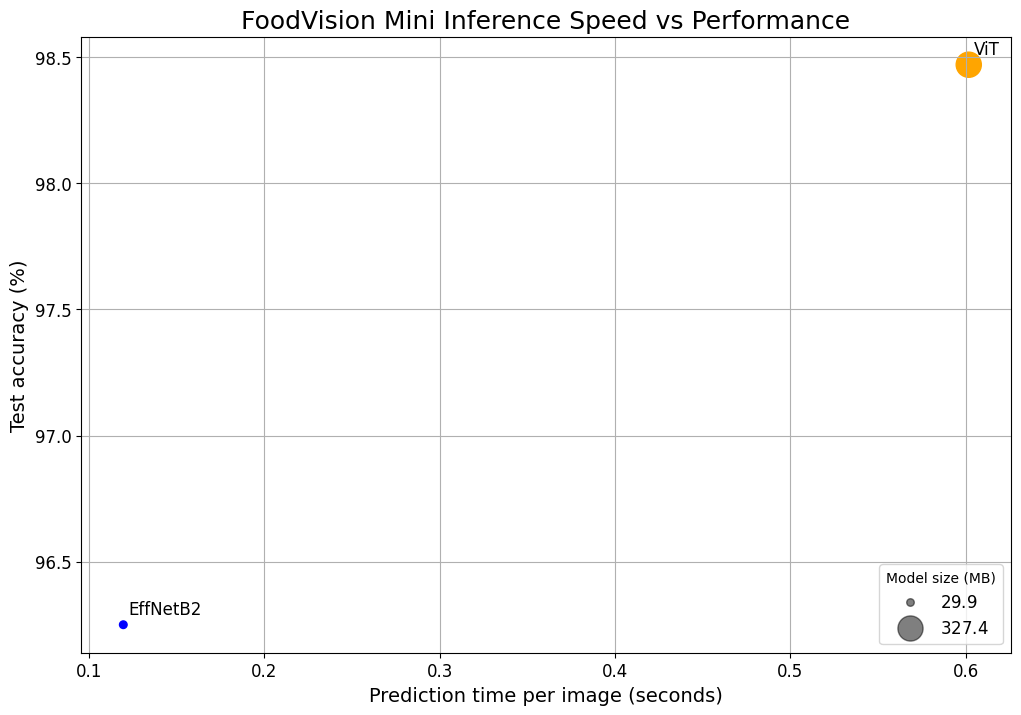

In [49]:
# 1. Create a plot from model comparison DataFrame
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)")

# 2. Add titles and labels
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

# 3. Annotate the samples on the scatter plot
for index, row in df.iterrows():
    ax.annotate(text=row["model"],
                xy=(row["time_per_pred_cpu"]+0.003, row["test_acc"]+0.04),
                size=12)

# 4. Create a legend based on the model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

plt.show()

# Save the figure
# plt.savefig("09-foodvision-mini-inference-speed-vs-performance.png")

## 7. Using Gradio demo on Food Vision Mini

See Gradio: https://www.gradio.app

In [50]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.3/140.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 5.2 MB/s eta 0:

### 7.1 Gradio overview

Gradio helps create ML demos.

Demos are useful for people that want to try out models, test them.
Deployment is as important as training

The overall premise of Gradio is to map inputs -> functions/models -> outputs

### 7.2 Create a function to map our inputs and outputs

In [51]:
# Put the model on the CPU
effnetb2 = effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

Create function called `predict()` to go from:

```
images of food -> ML model (EffNetB2) -> outputs (food class label)
```

In [52]:
from typing import Tuple, Dict


def predict(img) -> Tuple[Dict, float]:
    # Start timer
    start_time = timer()
    # Transform the input image for use with EffNetB2
    # unsqueeze to add batch dimension on 0th index
    img = effnetb2_transforms(img).unsqueeze(0)
    # Put the model into eval model, make prediction
    effnetb2.eval()
    with torch.inference_mode():
        # Pass transformed image on the model
        # and turn pred logits into probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    # Create a prediction label and pred prob dict
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate pred time
    end_time = timer()
    pred_time = round(end_time - start_time, 4)

    # Return pred dict and pred time
    return pred_labels_and_probs, pred_time

In [53]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[0]

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]
random_image_path

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Prediction on image at path: {random_image_path}\n")

# Predict on the target image and print out the outcomes
pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time)

[INFO] Prediction on image at path: data/pizza_steak_sushi_20_percent/test/pizza/3375083.jpg

{'pizza': 0.8142092227935791, 'steak': 0.10504944622516632, 'sushi': 0.0807412788271904}
0.1453


### 7.3 Creating a list of example images

Examples of Gradio can be seen here: https://www.gradio.app/docs/interface

In [54]:
# Create a list of exmaple inputs of the Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/911808.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/2997525.jpg']]

### 74. Building a Gradio interface

Using `gr.Interface()` to go from:

```
input: image -> transform -> predict with EffNetB2 -> output: pred, prob, time
```

In [55]:
# Create title, description, and article
title = "FoodVision Mini"
description = "An [EfficientNetB2](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.EfficientNet_B2_Weights) feature extractor computer vision model to classify images as pizza, steak or sushi"
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/#what-is-machine-learning-model-deployment)"

# Create the Gradio demo
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                            gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo
demo.launch(debug=False,
            share=True)  # Print erros locally? Also generate public URl

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://87e2f079010fcd7ac5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## 8. Turning the FoodVision Mini Gradio Demo into a deployable app

The Gradio links expire in 72h

Need to prepare the files to host them on Hugging Face Spaces.

### 8.1 Hugging Face spaces

Hugging Face Spaces offer a simple way to host ML demo apps directly on your profile or an organization's profile.

This allow you to create a ML portfolio and collaborate with others.
GitHub is a place to show your coding abilities, Hugging Face Spaces is useful to show your Ml and demo abilities.

See: https://huggingface.co/spaces

### 8.1 Deployed Gradio app structure

Put all of the app files into a single directory

```
Colab -> folder with all Gradio app files -> upload files to Hugging Face Spaces -> deploy
```

### 8.2 Deployed gradio app structure

To upload our demo Gradio app, we'll want to put everything relating to it into a single directory.

For example, our demo might live at the path demos/foodvision_mini/ with the file structure:
```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```
Where:

* `09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth` is our trained PyTorch model file.
* `app.py` contains our Gradio app (similar to the code that launched the app).
    * Note: `app.py` is the default filename used for Hugging Face Spaces, if you deploy your app there, Spaces will by default look for a file called app.py to run. This is changable in settings.
* `examples/` contain example images to use with our Gradio app.
model.py contains the model defintion as well as any transforms assosciated with the model.
* `requirement`.txt contains the dependencies to run our app such as torch, torchvision and gradio.

Why this way?

Because it's one of the simplest layouts we could begin with.

### 8.3 Creating `demos` folder to store our FoodVision app files

In [56]:
import shutil
from pathlib import Path

# Create FoodVision Mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini")

# Remove files that might exist and create a new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
    foodvision_mini_demo_path.mkdir(parents=True,
                                    exist_ok=True)
else:
    foodvision_mini_demo_path.mkdir(parents=True,
                                    exist_ok=True)

In [57]:
!ls demos/foodvision_mini/

### 8.4 Creating a folder of example images to use with the FoodVision mini demo

* 3 images ina an `examples/` directory
* Images should be from the test set

In [58]:
import shutil
from pathlib import Path

# Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# Collect three test dataset image paths (not random, picked 1 good image from each)
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# Copy the three images to the examples directory
for examples in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / examples.name
    print(f"[INFO] Copying {examples} to {destination}")
    shutil.copy2(src=examples, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


Verify if the Gradio demo is in a form of list, a list of list from the `examples/` directory

In [59]:
import os

# Get example flepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/592799.jpg'], ['examples/2582289.jpg'], ['examples/3622237.jpg']]

### 8.5 Moving the trained EffNetB2 model to the FoodVision Mini demo directory

In [60]:
import shutil

# Create a source path for the target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

 # Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the model file
try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path,
                dst=effnetb2_foodvision_mini_model_destination)
    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, it might have been moved.")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}")

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


### 8.6 Turning off EffNetB2 model into a Python script (`model.py`)

A `.pth` model `state_dict` was saved and needs to be loaded into a model instance.

* Move the `create_effnetb2_mode()` function to a script.

In [61]:
%%writefile demos/foodvision_mini/model.py

import torch
import torchvision
from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_mini/model.py


In [62]:
from demos.foodvision_mini import model

effnetb2_model, effnetb2_transforms_import = model.create_effnetb2_model()
effnetb2_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### 8.7 Turning the FoodVision Mini Gradio app into a Python script (`app.py`)

The `app.py` file will have four major parts:
1. Imports and class names setup
2. Model and tranforms preparation
3. Predict function (`predict()`)
4. Gradio app - Gradio interface and launch command

In [63]:
%%writefile demos/foodvision_mini/app.py
# 1. imports and class names set up
import gradio as gr
import os
import torch
from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Set up class names
class_names = ["pizza", "steak", "sushi"]

# 2. Model transforms and prep
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3)

# Load save weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu")
    )
)

# 3. Predict function
# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

# 4. Gradio app
# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


### 8.8 Creating a requirements file for FoodVision Mini (`requirements.txt`)

The requirements file will tell the Hugging Face Space what software dependencies the app requires

The three main ones are:
* `torch`
* `tochvision`
* `gradio`

In [64]:
%%writefile demos/foodvision_mini/requirements.txt
torch==2.0.1
torchvision==0.15.2
gradio==3.40.1

Writing demos/foodvision_mini/requirements.txt


## 9. Deploying the FoodVision Mini app on Hugging Face Spaces

There are two main options for uploading to a Hugging Face Space (also called a Hugging Face Repository, similar to a git repository):

* Uploading via the Hugging Face Web interface (easiest).
* Uploading via the command line or terminal.
    * Bonus: You can also use the huggingface_hub library to interact with Hugging Face, this would be a good extension to the above two options.

### 9.1 Downloading the FoodVision Mini app files

It is firts needed to download the `foodvision_mini` demo app before uploading it to Hugging Face Spaces

In [65]:
!ls demos/foodvision_mini

09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
app.py
examples
model.py
__pycache__
requirements.txt


In [66]:
# Change into foodvision_mini directory and zip it from the inside
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 57%)
  adding: examples/ (stored 0%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: model.py (deflated 55%)
  adding: requirements.txt (deflated 8%)


In [67]:
# Download
# try:
#     from google.colab import files
#     files.download("demos/foodvision_mini.zip")
# except:
#     print("Not running in Google Colab, cannot use google.colab.files.download(), please download manually.")

### 9.2 Running Gradio app locally


9.2 Running our FoodVision Mini demo locally
If you download the foodvision_mini.zip file, you can test it locally by:

* Unzipping the file.
* Opening terminal or a command line prompt.
* Changing into the foodvision_mini directory (`cd foodvision_mini`).
* Creating an environment (`python3 -m venv env`).
* Activating the environment (`source env/bin/activate`).
* Installing the requirements (`pip install -r requirements.txt`, the "-r" is for recursive).
    * Note: This step may take 5-10 minutes depending on your internet connection. And if you're facing errors, you may need to upgrade pip first: `pip install --upgrade pip`.
* Run the app (`python3 app.py`).

This should result in a Gradio demo just like the one we built above running locally on your machine at a URL such as http://127.0.0.1:7860/.


### 9.3 Uploading the FoodVision Mini Gradio demo to Hugging Face Spaces

Using terminal. For model bigger than 10MB, use Git LFS to upload and commit: https://git-lfs.com/

## Try out the model

Sharing the app by embedding it.
See "Embed this space" in Hugging Face Spaces

In [68]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
IFrame(src="https://kenwatanabe-foodvision-pytorch.hf.space", width=900, height=750)

## 10. Creating FoodVision Big

FoodVision Mini worked well for 3 clases.

Next - 101 classes.

### 10.1 Creating a model for FoodVision Big and transforms

In [69]:
# Create Food101 model and transform
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

In [70]:
# Summary after classifier update
summary(effnetb2_food101,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Since the dataset is larger, some data augmentation techniques can be implemented. Larger datasets and models can show overfitting.

We are going to use TrivialAugment as the data Augmentaion technique.

For a list of state of the art computer vision techniques: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [71]:
# Creating training data transforms
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms])

In [72]:
food101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [73]:
# Testing data transforms
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### 10.2 Getting data for FoodVision Big

Food101 dataset: https://pytorch.org/vision/stable/generated/torchvision.datasets.Food101.html#torchvision.datasets.Food101

In [74]:
from torchvision import datasets

# Set up data directory
from pathlib import Path
data_dir = Path("data")

# Get the training data (75750 training and 25250 test images)
train_data = datasets.Food101(root=data_dir,
                              split="train",
                              transform=food101_train_transforms,
                              download=True)

test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms,
                             download=True)

100%|██████████| 4996278331/4996278331 [03:30<00:00, 23680577.55it/s]


Extracting data/food-101.tar.gz to data


In [75]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### 10.3 Creating a subset of the Food101 datasets for daster experimenting

FoodVision Mini works well, but now we have 101 classes.
The firts experiments need to run as fast as possible

* Take 20% of the train and test data
* Beat the 56.40% accuracy on the test dataset from the original article: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

In [76]:
from torch.utils.data import random_split


def split_dataset(dataset: torchvision.datasets,
                  split_size:float=0.2,
                  seed:int=42):
    length_1 = int(len(dataset) * split_size)
    length_2 = len(dataset) - length_1

    # Print out info
    print(f"[INFO] Splitting dataset of lenghts {len(dataset)} into splits of size: {length_1} and {length_2}")

    # Creat splits with given rando seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed))

    return random_split_1, random_split_2

In [77]:
# Create training 20% split Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                  split_size=0.2)

# Create testing 20% split Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

[INFO] Splitting dataset of lenghts 75750 into splits of size: 15150 and 60600
[INFO] Splitting dataset of lenghts 25250 into splits of size: 5050 and 20200


In [78]:
len(train_data_food101_20_percent), len(test_data_food101_20_percent)

(15150, 5050)

### 10.5 Turning Food101 datasets into `DataLoader`s

In [79]:
import torch

BATCH_SIZE = 32
NUM_WORKERS = 2  # This value is very experimental, best value will differ

# Create Food101 training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)

# Create Food101 20% test DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(dataset=test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

In [80]:
len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent)

(474, 158)

### 10.5 Training FoodVision Big

For training:

* 5 epochs
* Optimizer = `torch.optim.Adam(lr=1e-3)`
* Loss function = `torch.nn.CrossEntropyLoss(label_smoothing=0.1)`

Label smothing is a regularization technique that helps to prevent overfitting.
Without label smoothing and 5 classes:

```
[0.00, 0.00, 0.99, 0.01, 0.00]
```

With label smoothing and 5 classes:

```
[0.01, 0.01, 0.96, 0.01, 0.01]
```

In [81]:
from going_modular.going_modular import engine

# Set up the optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

# Set up loss
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Train
set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6422 | train_acc: 0.2795 | test_loss: 2.7824 | test_acc: 0.4903
Epoch: 2 | train_loss: 2.8626 | train_acc: 0.4410 | test_loss: 2.4729 | test_acc: 0.5334
Epoch: 3 | train_loss: 2.6559 | train_acc: 0.4866 | test_loss: 2.3633 | test_acc: 0.5556
Epoch: 4 | train_loss: 2.5455 | train_acc: 0.5124 | test_loss: 2.3022 | test_acc: 0.5751
Epoch: 5 | train_loss: 2.4963 | train_acc: 0.5235 | test_loss: 2.2799 | test_acc: 0.5810


### 10.6 Inspecting loss curves of the FoodVision Big model

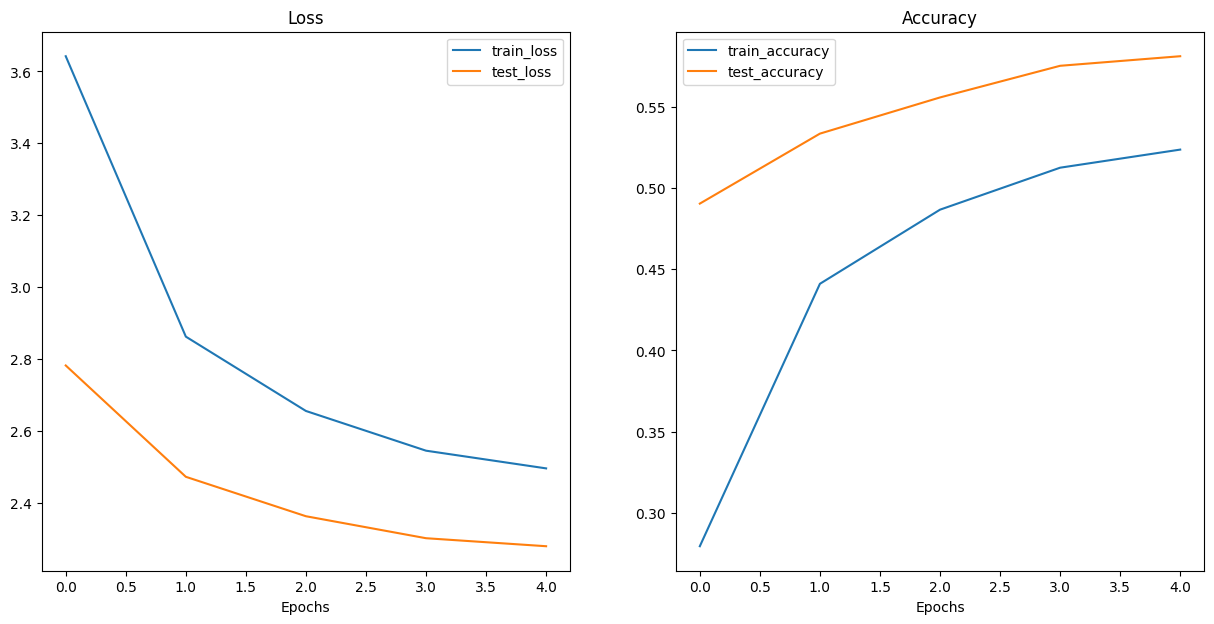

In [82]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_food101_results)

### 10.7 Save and load FoodVision Big model

In [83]:
from going_modular.going_modular import utils

# Create a model path
effnetb2_food101_model_path = "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

# Save FoodVision Big model
utils.save_model(model=effnetb2_food101,
                 target_dir="models",
                 model_name=effnetb2_food101_model_path)

# Create Food101 compatible EffNetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# load the save model's state_dict()
loaded_effnetb2_food101.state_dict(torch.load("models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"))

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1802: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


OrderedDict([('features.0.0.weight',
              tensor([[[[ 4.5455e-02,  7.6288e-02,  3.0048e-02],
                        [ 5.5432e-01,  2.9662e-01, -3.1593e-02],
                        [ 7.8309e-01,  2.3778e-01, -7.0381e-02]],
              
                       [[-2.9542e-01, -2.2617e-01,  4.4444e-02],
                        [-1.1007e+00, -7.1409e-01, -5.0454e-02],
                        [-1.4469e+00, -6.2652e-01, -6.3332e-03]],
              
                       [[ 2.2284e-01,  1.2584e-01, -2.9721e-02],
                        [ 6.2338e-01,  4.4390e-01,  4.5707e-02],
                        [ 6.7145e-01,  4.5727e-01,  7.3647e-03]]],
              
              
                      [[[-3.9284e-02, -2.5299e-02,  1.4641e-02],
                        [ 5.2415e-02, -2.0318e-01,  1.3882e-01],
                        [ 9.2027e-02, -9.3667e-01,  9.1768e-01]],
              
                       [[-7.7375e-02, -2.6244e-02,  4.9299e-02],
                        [ 2.1007e-01, 

### 10. Checking FoodVision Big model size

In [84]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024 * 1024)
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


## 11. Turning the FoodVision Big model into a deployable app

Deploy our FoodVision Big model in the same way we deployed our FoodVision Mini model, as a Gradio demo on Hugging Face Spaces.

Create a demos/foodvision_big/ directory to store our FoodVision Big demo files as well as a demos/foodvision_big/examples directory to hold an example image to test the demo with.

When finished, it will have the following file structure:

```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt
```

In [85]:
from pathlib import Path

# Create FoodVision Big demo Path
foodvision_big_demo_path = Path("demos/foodvision_big/")

# Make FoodVision Big demo directory
foodvision_big_demo_path.mkdir(parents=True,
                               exist_ok=True)

# Make FoodVision big demo examples directory
(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

### 11.1 Dowloading an example image and moving it to the `examples` directory

In [86]:
# Download and move an example image
!wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpg

# Move trained model to FoodVision Big demo folder (will error if model is already moved)
!mv models/09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth demos/foodvision_big

--2023-08-16 13:14:36--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.07s   

2023-08-16 13:14:37 (41.3 MB/s) - ‘04-pizza-dad.jpeg’ saved [2874848/2874848]



### 11.2 Saving Food101 class names to file (`class_names.txt`)

Save all classe names of the Food101 dataset to a .txt file to import and use in the app.

In [87]:
# Create a path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"
foodvision_big_class_names_path

PosixPath('demos/foodvision_big/class_names.txt')

In [88]:
# Write Food101 class names to text file
with open(foodvision_big_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to: {foodvision_big_class_names_path}")
    f.write("\n".join(food101_class_names))  # new line per class name

[INFO] Saving Food101 class names to: demos/foodvision_big/class_names.txt


In [89]:
# Open Food101 class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
    food101_class_names_loaded = [food.strip() for food in f.readlines()]

food101_class_names_loaded

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

### 11.3 Turning our FoodVision Big model into a Python script (`model.py`)

In [90]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_big/model.py


### 11.4 Turning the FoodVision Big Gradio app into a Python script(`app.py`)

* 1. Imports and class names setup - The class_names variable will be a list for all of the Food101 classes. It is possible to access the classes via demos/foodvision_big/class_names.txt.
* 2. Model and transforms preparation - The model will have num_classes=101 rather than num_classes=3. The weights are loaded from "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth" (FoodVision Big model path).
* 3. Predict function - This will stay the same as FoodVision Mini's app.py.
* 4. Gradio app - The Gradio interace will have different title, description and article parameters to reflect the details of FoodVision Big.

In [91]:
%%writefile demos/foodvision_big/app.py
# 1. Imports and class names set up
import gradio as gr
import os
import torch
from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Set up class names
with open("class_names.txt", "r") as f:
    class_names = [food_name.strip() for food_name in  f.readlines()]

# 2. Model and transforms preparation
# Create model and transforms
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load the saved weights
effnetb2.load_state_dict(
    torch.load(f="09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
               map_location=torch.device("cpu")))

# 3. Predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

# 4. Gradio app
# Create title, description and article strings
title = "FoodVision Big 🍔👁"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food into [101 different classes](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the app
demo.launch()

Writing demos/foodvision_big/app.py


### 11.5 Creating a requirements file for FoodVision Big

In [92]:
%%writefile demos/foodvision_big/requirements.txt
torch==2.0.1
torchvision==0.15.2
gradio==3.40.1

Writing demos/foodvision_big/requirements.txt


### 11.6 Downloading the FoodVision Big files

In [94]:
# Zip foodvision_big folder but exclude certain files
# !cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Big app (if running in Google Colab)
# try:
#     from google.colab import files
#     files.download("demos/foodvision_big.zip")
# except:
#     print("Not running in Google Colab, cannot use google.colab.files.download()")

updating: 09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth (deflated 8%)
updating: app.py (deflated 54%)
updating: class_names.txt (deflated 48%)
updating: examples/ (stored 0%)
updating: examples/04-pizza-dad.jpg (deflated 0%)
updating: model.py (deflated 55%)
updating: requirements.txt (deflated 8%)


# See the FoodVision Big Running!

https://huggingface.co/spaces/kenwatanabe/foodvision_big